<a href="https://colab.research.google.com/github/dishant199/1/blob/new/BERT_ner_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers seqeval[gpu]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=216131f48fa13553a3fd41615358bb6fd92f5505e2cba20e95ccc97885cc903c
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
df = pd.read_csv('Custom_ner.csv')

In [ ]:
df

,text,entities
0,Sentence,O
1,Thousands,QUANTITY
2,of,O
3,demonstrators,O
4,have,O
...,...,...
36637,Burma,O
36638,has,O
36639,confirmed,O
36640,additional,O


In [ ]:
data = pd.DataFrame([],columns=['sentence','word_labels'])
t = ''
c = ''
for indx,line in df.iterrows():
  t = t + line['text'] + ' '
  c = c + line['entities'] + ','

  if line['text'] == '.':
    data.loc[len(data)] = [t.strip(),c[:-1]]
    t = ''
    c = ''
data.loc[len(data)] = [t.strip(),c[:-1]]

In [ ]:
data

,sentence,word_labels
0,Sentence Thousands of demonstrators have march...,"O,QUANTITY,O,O,O,O,O,COUNTRY,O,O,O,ATTACKS,O,C..."
1,""" Families of soldiers killed in the conflict ...","O,O,O,ARMY,ATTACKS,O,O,O,O,O,ORGANISATION,O,O,..."
2,""" "" "" They marched from the Houses of Parliame...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,PERSON,O,O"
3,""" Police put the number of marchers at 10,000 ...","O,ARMY,O,O,O,O,O,O,QUANTITY,O,O,O,O,O,QUANTITY,O"
4,""" The protest comes on the eve of the annual c...","O,O,O,O,O,O,O,O,O,TIME,O,O,COUNTRY,O,O,O,O,O,O..."
...,...,...
1535,""" The agreement gives Peru permanent , duty - ...","O,O,O,O,O,O,O,O,O,QUANTITY,O,O,O,COUNTRY,O,O,O..."
1536,""" "" The pact was initially approved after disc...","O,O,O,TREATY,O,O,O,O,O,O,O,O,O,DAY,O,O,O,O,O,G..."
1537,""" Peru 's Congress this week passed modificati...","O,O,O,O,O,O,O,O,O,ARMY,O,O,O,O,O,O,TREATY,O"
1538,The agreement will take effect on the first of...,"O,O,O,O,O,O,O,O,O,O,O"


In [ ]:
label2id = {k: v for v, k in enumerate(df.entities.unique())}
id2label = {v: k for v, k in enumerate(df.entities.unique())}
label2id

{'O': 0,
 'QUANTITY': 1,
 'COUNTRY': 2,
 'ATTACKS': 3,
 'ARMY': 4,
 'ORGANISATION': 5,
 'PERSON': 6,
 'TIME': 7,
 'LOCATION': 8,
 'COMPOUND': 9,
 'DAY': 10,
 'BUILDINGS': 11,
 'EVENT': 12,
 'GOVERNMENT': 13,
 'TREATY': 14,
 'DATE': 15}

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1540, 2)
TRAIN Dataset: (1232, 2)
TEST Dataset: (308, 2)


In [ ]:
training_set[0]

{'ids': tensor([  101,  1000,  1000,  2174,  1010,  1996, 18883,  2529,  2916, 16823,
          4402, 23325,  6633,  6683, 12322,  3669,  2855,  2357,  2091,  1996,
          2695,  1010,  2975,  1037,  2309, 15619,  1999,  1996,  3943,  1011,
          2266,  5239,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [ ]:
training_set[0]["ids"]

tensor([  101,  1000,  1000,  2174,  1010,  1996, 18883,  2529,  2916, 16823,
         4402, 23325,  6633,  6683, 12322,  3669,  2855,  2357,  2091,  1996,
         2695,  1010,  2975,  1037,  2309, 15619,  1999,  1996,  3943,  1011,
         2266,  5239,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
# print the first 30 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:30]), training_set[0]["targets"][:30]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))

[CLS]       O
"           O
"           O
however     O
,           O
the         O
sunni       LOCATION
human       O
rights      O
appoint     O
##ee        O
hash        O
##em        O
ash         O
##ib        O
##li        O
quickly     ARMY
turned      O
down        O
the         O
post        O
,           O
leaving     O
a           O
single      O
vacancy     O
in          O
the         O
33          QUANTITY
-           O


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(2.6226, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 16])

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)


In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    return epoch_loss, tr_accuracy
    # print(f"Training loss epoch: {epoch_loss}")
    # print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
epoch_loss, tr_accuracy = [],[]
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    loss, acc = train(epoch)
    epoch_loss.append(loss)
    tr_accuracy.append(acc)

Training epoch: 1
Training loss per 100 training steps: 2.727248430252075
Training loss per 100 training steps: 0.4890165596757785
Training loss per 100 training steps: 0.3181477007062281
Training loss per 100 training steps: 0.254611672183802
Training epoch: 2
Training loss per 100 training steps: 0.120069220662117
Training loss per 100 training steps: 0.1100087196815132
Training loss per 100 training steps: 0.10106072860274148
Training loss per 100 training steps: 0.09776633232831955
Training epoch: 3
Training loss per 100 training steps: 0.03698895126581192
Training loss per 100 training steps: 0.07415588290458268
Training loss per 100 training steps: 0.07609627287445674
Training loss per 100 training steps: 0.07376557514318992


In [ ]:
import matplotlib.pyplot as plt


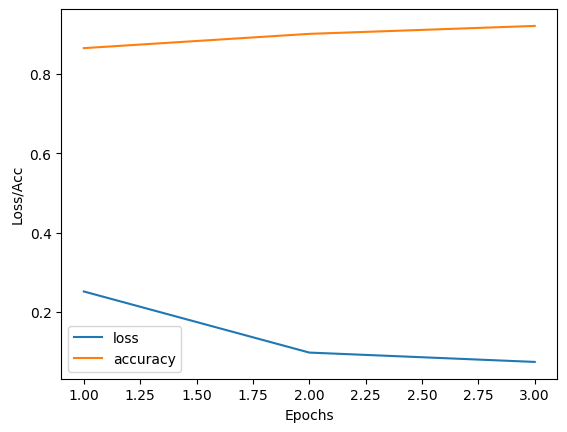

In [ ]:
plt.plot(range(1,4),epoch_loss,label='loss')
plt.plot(range(1,4),tr_accuracy,label='accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Acc')
plt.show()

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model, testing_loader)


Validation loss per 100 evaluation steps: 0.044422268867492676
Validation loss per 100 evaluation steps: 0.06577142565004011
Validation Loss: 0.06768763240112306
Validation Accuracy: 0.9281627643424382


In [ ]:
df['entities'].unique()

array(['O', 'QUANTITY', 'COUNTRY', 'ATTACKS', 'ARMY', 'ORGANISATION',
       'PERSON', 'TIME', 'LOCATION', 'COMPOUND', 'DAY', 'BUILDINGS',
       'EVENT', 'GOVERNMENT', 'TREATY', 'DATE'], dtype=object)

In [ ]:
np.unique(predictions)

array(['ARMY', 'ATTACKS', 'COMPOUND', 'COUNTRY', 'DATE', 'DAY',
       'GOVERNMENT', 'LOCATION', 'O', 'PERSON', 'QUANTITY'], dtype='<U10')

In [ ]:
predictions = [' '+i for i in predictions]
labels = [' '+i for i in labels]

In [ ]:
from seqeval.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

print(classification_report([labels], [predictions],zero_division=True))

              precision    recall  f1-score   support

        ARMY       0.86      0.53      0.66       121
     ATTACKS       0.77      0.62      0.68        81
   BUILDINGS       1.00      0.00      0.00         5
    COMPOUND       0.88      0.30      0.45        70
     COUNTRY       0.47      0.74      0.57       152
        DATE       0.84      0.80      0.82        20
         DAY       0.94      0.65      0.77       104
       EVENT       1.00      0.00      0.00         7
  GOVERNMENT       1.00      0.04      0.08        24
    LOCATION       0.46      0.30      0.36        54
           O       0.44      0.35      0.39       744
ORGANISATION       1.00      0.00      0.00        23
      PERSON       0.33      0.03      0.05        67
    QUANTITY       0.63      0.76      0.69        88
        TIME       1.00      0.00      0.00         9
      TREATY       1.00      0.00      0.00         3

   micro avg       0.55      0.43      0.48      1572
   macro avg       0.79   

In [ ]:
def getNER(sentence):
  inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

  # move to gpu
  ids = inputs["input_ids"].to(device)
  mask = inputs["attention_mask"].to(device)
  # forward pass
  outputs = model(ids, mask)
  logits = outputs[0]

  active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
  flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

  tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
  token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
  wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

  word_level_predictions = []
  for pair in wp_preds:
    if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
      # skip prediction
      continue
    else:
      word_level_predictions.append(pair[1])

  # we join tokens, if they are not special ones
  str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
  print(str_rep)
  print(word_level_predictions)

In [ ]:
sentence = "@HuggingFace is a company based in New York, but is also has employees working in Paris"
getNER(sentence)

@ huggingface is a company based in new york , but is also has employees working in paris
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
sentence = 'This is trial'
getNER(sentence)

this is trial
['O', 'O', 'O']


In [ ]:
sentence = 'Britain'
getNER(sentence)

britain
['O']


In [ ]:
sentence = 'America'
getNER(sentence)

america
['O']
